In [1]:
from scipy.stats import poisson
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

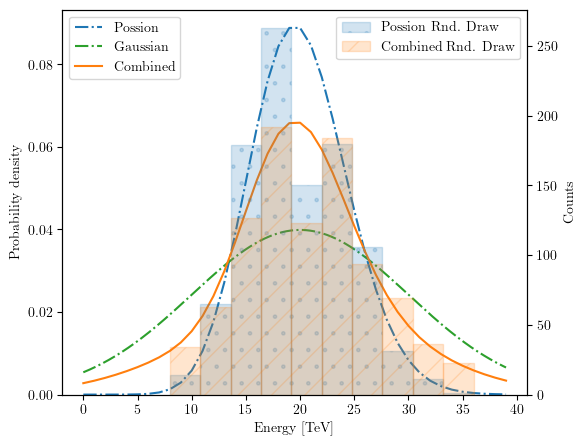

In [17]:
xmax = 40
mu_g = 20
sigma_g = 10
mu_p = 20


#fig,ax = plt.subplots(1,1, figsize=(4, 3))
fig,ax = plt.subplots(1,1, figsize=(6, 5))

k_values = np.array(list(range(0, xmax)))
pmf_values = [poisson.pmf(k, mu=mu_p) for k in k_values]

def gaussian(x, mu, sigma, norm = 1):
    return norm / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

x = np.linspace(0, k_values[-1], 1000)
y = gaussian(k_values, mu_g, sigma_g)
y_fine = gaussian(x, mu_g, sigma_g)
prob_ges = pmf_values+ y
prob_ges /= np.sum(prob_ges)
pmf_values /= np.sum(pmf_values)
y /= np.sum(y)

ax.plot(k_values, pmf_values , label = "Possion" , linestyle = '-.')
ax.plot(x, y_fine, label = "Gaussian", color = 'tab:green', linestyle = '-.')
ax.plot(k_values, prob_ges, label = "Combined", linestyle = '-')
ax.set_ylim(0, ax.get_ylim()[1])
plt.xlabel('Energy [TeV]')
plt.ylabel('Probability density')

ax2 = ax.twinx()

size = int(1e3)
samples = np.random.choice(k_values, size=size, p=pmf_values)
c, bins, _ = ax2.hist(samples, density= False, label = "Possion Rnd. Draw", alpha = 0.2, hatch = '.', edgecolor = 'tab:blue')

samples = np.random.choice(k_values, size=size, p=prob_ges)
c, bins, _ = ax2.hist(samples, bins = bins, density= False, label = "Combined Rnd. Draw", alpha = 0.2, hatch = '/', edgecolor = 'tab:orange')
ax2.set_ylabel("Counts")
ax.legend(loc = 'upper left')
ax2.legend(loc = 'upper right')

plt.show()

In [4]:
from scipy.special import factorial

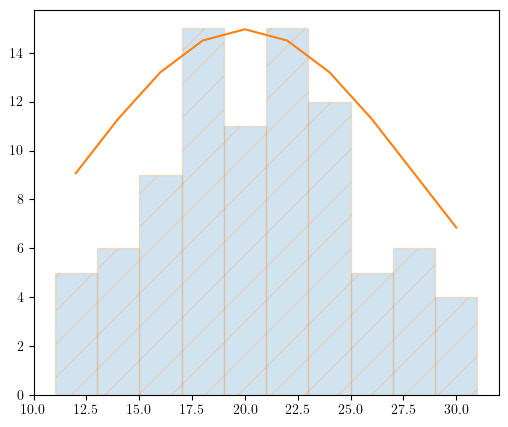

In [5]:
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
mu_guess = 20
sigma_guess = 8
norm_guess = 3e2
bin_center = (bins[1:] + bins[:-1] )/2
model_pred =  gaussian(bin_center, mu_guess, sigma_guess, norm_guess)

L = samples

fig,ax = plt.subplots(1,1, figsize=(6, 5))

c, bins, _ = ax.hist(samples, bins = bins, density= False, label = "Combined Rnd. Draw", alpha = 0.2, hatch = '/', edgecolor = 'tab:orange')
ax.plot(bin_center, model_pred)


In [6]:
def Likelihood_cost( mu, sigma, norm):
    mu = gaussian(bin_center, mu, sigma, norm )
    #L = mu ** c  * np.exp(- mu)
    L = np.sum(mu - c * np.log(mu))
    return L

In [7]:
#Fitting:
from  iminuit import Minuit
minuit = Minuit(Likelihood_cost, mu = mu_guess, sigma = sigma_guess, norm = norm_guess)
m = minuit.migrad()
print(m)


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -110.6                     │              Nfcn = 93               │
│ EDM = 1.04e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬─────

In [8]:
# Print the estimated parameters and their uncertainties
print(f"The estimated parameters are: {m.values}")
print(f"The parameter uncertainties are: {m.errors}")

The estimated parameters are: <ValueView mu=20.426629096923588 sigma=5.699336684023425 norm=191.1525361561576>
The parameter uncertainties are: <ErrorView mu=1.056168964618494 sigma=1.1546508591530569 norm=31.547525689206353>


In [10]:
def prior(mu, sigma_sys, norm_sys):
    g = gaussian(bin_center, mu, sigma_sys, norm_sys)
    print("g", g)
    print("mu, sigma_sys, norm_sys", mu, sigma_sys, norm_sys)
    #return (g)
    return np.log(np.product(g))



In [11]:
def Likelihood_prior_cost( mu, sigma, norm, sigma_sys, norm_sys):
    print()
    print("mu", mu, "sigma", sigma, "norm", norm," sigma_sys", sigma_sys," norm_sys", norm_sys)
    mu = gaussian(bin_center, mu, sigma, norm )
    sys = gaussian(bin_center, mu, sigma_sys, norm_sys )
    mu += sys
    #L = mu ** c  * np.exp(- mu)
    L = np.sum(mu - c * np.log(mu))
    p = prior(mu, sigma_sys, norm_sys)
    print("L, pr", L, p)
    return L # +p

In [12]:
#Fitting:
from  iminuit import Minuit
sigma_sys = 1
norm_sys = 1
#minuit_prior = Minuit(Likelihood_prior_cost, mu = mu_guess, sigma = sigma_guess, norm = norm_guess, sigma_sys = sigma_sys, norm_sys =norm_sys)
minuit_prior = Minuit(prior, mu = mu_guess, sigma_sys = sigma_sys, norm_sys =norm_sys)
m_prior = minuit_prior.migrad()
print(m_prior)


g [5.05227108e-15 6.07588285e-09 1.33830226e-04 5.39909665e-02
 3.98942280e-01 5.39909665e-02 1.33830226e-04 6.07588285e-09
 5.05227108e-15 7.69459863e-23]
mu, sigma_sys, norm_sys 20.0 1.0 1.0
g [4.97206806e-15 6.00339597e-09 1.32763590e-04 5.37753264e-02
 3.98941483e-01 5.42072545e-02 1.34904892e-04 6.14922036e-09
 5.13374731e-15 7.85002413e-23]
mu, sigma_sys, norm_sys 20.002 1.0 1.0
g [5.13374731e-15 6.14922036e-09 1.34904892e-04 5.42072545e-02
 3.98941483e-01 5.37753264e-02 1.32763590e-04 6.00339597e-09
 4.97206806e-15 7.54222028e-23]
mu, sigma_sys, norm_sys 19.998 1.0 1.0
g [5.08419601e-15 6.09718244e-09 1.34031090e-04 5.40071633e-02
 3.98902390e-01 5.40071633e-02 1.34031090e-04 6.09718244e-09
 5.08419601e-15 7.77114186e-23]
mu, sigma_sys, norm_sys 20.0 1.0001 1.0
g [5.02053703e-15 6.05465119e-09 1.33629600e-04 5.39747687e-02
 3.98982179e-01 5.39747687e-02 1.33629600e-04 6.05465119e-09
 5.02053703e-15 7.61878654e-23]
mu, sigma_sys, norm_sys 20.0 0.9999 1.0
g [5.14592342e-15 6.13819

/tmp/ipykernel_3306098/2667392975.py:6: RuntimeWarning: divide by zero encountered in log
  return np.log(np.product(g))


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1103: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1104: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])


<ErrorbarContainer object of 3 artists>

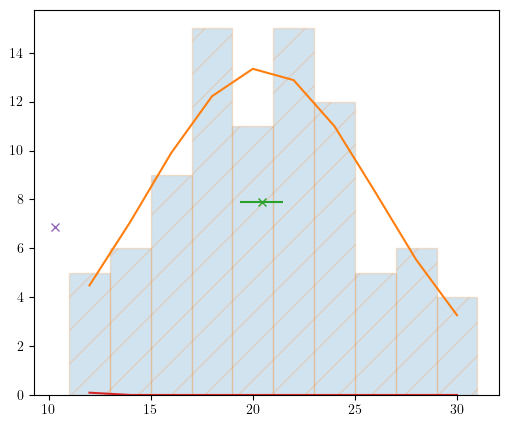

In [13]:
fig,ax = plt.subplots(1,1, figsize=(6, 5))
c, bins, _ = ax.hist(samples, bins = bins, density= False, label = "Combined Rnd. Draw", alpha = 0.2, hatch = '/', edgecolor = 'tab:orange')


model_pred_after_fit =  gaussian(bin_center, m.values[0], m.values[1], m.values[2])
ax.plot(bin_center, model_pred_after_fit)
plt.errorbar(x = m.values[0], y = ax.get_ylim()[1]/2, xerr = m.errors[0],fmt= 'x')


model_pred_after_fit_prior =  gaussian(bin_center, m_prior.values[0], m_prior.values[1], m_prior.values[2])
ax.plot(bin_center, model_pred_after_fit_prior)
plt.errorbar(x = m_prior.values[0], y = ax.get_ylim()[1]/2-1, xerr = m_prior.errors[0],fmt= 'x')

In [14]:
sdf

NameError: name 'sdf' is not defined

In [ ]:
import numpy as np
from iminuit import Minuit

# Define your model
def my_model(x, a, b, c):
    return a * np.exp(-b * x) + c

# Define the negative log-likelihood function
def nll(a,b,c,):
    model = my_model(x, a, b, c)
    return np.sum(model - data * np.log(model))

# Generate some random data
x = np.linspace(0, 10, 100)
data = my_model(x, 2.5, 1.3, 0.5) + np.random.normal(0, 0.1, len(x))

# Perform the maximum likelihood fit
m = Minuit(nll, a=1, b=1, c=1,)
m.migrad()

# Print the estimated parameters and their uncertainties
print(f"The estimated parameters are: {m.values}")
print(f"The parameter uncertainties are: {m.errors}")


In [ ]:
dsf

In [ ]:
theta_ML = np.where(L == np.max(L))[0][0]
errorpos_theta_ML =np.where(L[theta_ML:] <= (np.max(L) - 2)  )
errorpos_theta_ML =  xinter[errorpos_theta_ML[0][0]]

errorneg_theta_ML =np.where(L[:theta_ML] <= (np.max(L) - 2)  )
errorneg_theta_ML = xinter[theta_ML] - xinter[errorneg_theta_ML[0][-1]] 

print("errorneg_theta_ML", errorneg_theta_ML)
print("errorpos_theta_ML", errorpos_theta_ML)
print(theta_ML)
plt.errorbar(x = lamda, y = 5, 
             xerr = np.sqrt(lamda),
            fmt = 'x',color = 'red', label = f"Mean pm Variance :{lamda} pm {np.sqrt(lamda):.3} ")
plt.errorbar(x = xinter[theta_ML], y = 2, 
             xerr = (errorneg_theta_ML),
            fmt = 'x',color = 'green', 
             label = f"Maximum Likelihood \nEstimator:{xinter[theta_ML]:.4} pm {errorneg_theta_ML:.4}")
ax.plot(xinter,  L,
        label='Likelihood function')
plt.xlabel("Signal Strength [arb. unit]")
plt.ylabel("Amount of Signal")

plt.legend()
plt.show()

In [ ]:
def Gauss(bins, mu, sigma):
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2))

In [ ]:
mu, sigma = 0, 1 # mean and standard deviation

sys = np.random.normal(mu, sigma, size)

count, bins, ignored = plt.hist(sys, 99, density=True)
G = Gauss(bins, mu, sigma)
plt.plot(bins, G ,
         linewidth=2, color='r')

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1)
max_,bins , _ = plt.hist(sys+11, label = "sys", color = 'red' ,
                        alpha = 0.4)

ax.plot(xinter,  L, label='Likelihood function')
G = Gauss(xinter, lamda, sigma)
G = G/np.max(G) * np.max(max_)
print(G)
ax.plot(xinter, G, label='Prior')


plt.legend()
plt.xlabel("Signal Strength [arb. unit]")
plt.ylabel("Amount of Signal")


In [ ]:
poisson.rvs(mu=lamda+sys[0], size=1)

In [ ]:
def L (theta, x ):
    l = []
    for xi in x:
        l.append( theta**xi * np.exp(-theta))
    return l

In [ ]:
l = L (theta= 10, x = range(30))
print(l)
plt.plot(range(30), l)

In [ ]:
fig, ax = plt.subplots(1, 1)

poisson_draws_sys = []
for i in range((size)):
    p = poisson.rvs(mu=lamda+sys[i], size=1)[0]
    poisson_draws_sys.append(p)

max_,bins , _ = plt.hist(poisson_draws_sys, label = "Data+sys", color = 'orange' ,
                        alpha = 0.9)
max_,bins , _ = plt.hist(poisson_draws, label = "Data",  color = 'tab:blue')
max_,bins , _ = plt.hist(sys+11, label = "sys", color = 'green' ,alpha = 0.99)

ax.plot(xinter,  L, label='Likelihood function')
G = Gauss(xinter, lamda, sigma)
G = G/np.max(G) * np.max(max_)
P = L* G 
P = P/np.max(P) * np.max(max_)
ax.plot(xinter, P, label='Posterior function')
ax.plot(xinter, G, label='Prior')

plt.legend()
plt.xlabel("Signal Strength [arb. unit]")
plt.ylabel("Amount of Signal")


In [ ]:
G

In [ ]:
import numpy as np

# Set the value of lambda
lam = 10

# Generate Poisson-distributed random numbers
poisson_data = np.random.poisson(lam, size=1000)

# Generate normally-distributed random numbers
gaussian_data = np.random.normal(size=1000)

# Add the two sets of random numbers together
simulated_data = poisson_data + gaussian_data

# Print the first 10 values of the simulated data
print(simulated_data[:10])
plt.hist(simulated_data)
plt.hist(poisson_data)
plt.hist(gaussian_data)